# **Recurrent Neural Network (RNN)**

---

## **Introduction**

Recurrent Neural Network (RNN) is a type of neural network designed to handle sequential data. It maintains a memory of past inputs using recurrent connections, making it suitable for time-series data, natural language, and EEG signals in BCI (Brain-Computer Interface) systems.

**Core ideas of RNN:**
- Hidden State Memory  
- Parameter Sharing over Time  
- Sequence-to-Value or Sequence-to-Sequence Mapping  

---

## **Basic Structure**

RNN processes input sequences step by step, maintaining a hidden state vector that captures historical information.

At each time step $t$, given input vector $x_t$, and previous hidden state $h_{t-1}$, the RNN computes:

### **(1) Hidden State Update**

$$
h_t = \phi(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

Where:
- $x_t \in \mathbb{R}^{d_{in}}$: input at time step $t$  
- $h_t \in \mathbb{R}^{d_{h}}$: hidden state at time $t$  
- $W_{xh} \in \mathbb{R}^{d_{h} \times d_{in}}$: input weight  
- $W_{hh} \in \mathbb{R}^{d_{h} \times d_{h}}$: recurrent weight  
- $b_h \in \mathbb{R}^{d_h}$: bias  
- $\phi$: non-linear activation function (e.g., $\tanh$, ReLU)

---

### **(2) Output Layer**

At each time step or after the entire sequence, the RNN outputs a prediction:

$$
\hat{y}_t = W_{hy} h_t + b_y
$$

Where:
- $W_{hy} \in \mathbb{R}^{d_{out} \times d_h}$: output weight  
- $b_y \in \mathbb{R}^{d_{out}}$: output bias  
- $\hat{y}_t$: output at time $t$ (for regression or classification)

---

## **RNN Characteristics**

| Property | Description |
|----------|-------------|
| Temporal Dependency | Maintains history via $h_t$ |
| Weight Sharing | Same weights used at each time step |
| Online Computation | Suitable for real-time decoding |
| Simple & Interpretable | Mathematical formulation is straightforward |

---

## **Limitations of Vanilla RNN**

| Problem | Description |
|---------|-------------|
| Vanishing Gradient | Gradients diminish over time, hard to learn long-term dependencies |
| Exploding Gradient | Unstable training for long sequences |
| Short-Term Memory | Struggles to remember distant history |
| Sequential Bottleneck | Cannot parallelize time steps during training |

---

## **Application Scenarios**

RNN is widely used in:

- Time Series Forecasting  
- Sequence Labeling  
- EEG Sequence Regression  
- Signal Classification  
- Natural Language Processing (e.g., POS tagging, speech recognition)

---

## **RNN in BCI**

### Typical Use Cases:
- Predicting continuous control signals (e.g., steering angles)  
- Classifying sequential EEG epochs  
- Decoding motor imagery or mental workload over time  

### Advantages in BCI:
- Fits naturally with EEG temporal dynamics  
- Simple architecture, quick to train  
- Suitable for online streaming EEG decoding  

---

## **Prerequisites**

- `numpy`  
- `torch`  
- `matplotlib`  
- `scikit-learn`  

---

In practice, RNNs are often extended to LSTM and GRU to address memory limitations.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

from utils import (
    load_data_model,
)

# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward1.npz"
data_list = load_data_model(data_dir)
train_data, train_label = data_list["feature_train"], data_list["steering_train"]
test_data, test_label = data_list["feature_test"], data_list["steering_test"]

In [3]:
# DataLoader
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
                              torch.tensor(train_label, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32),
                             torch.tensor(test_label, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
class EEG_RNN(nn.Module):
    def __init__(self, input_size=63, hidden_size=128, num_layers=1):
        super(EEG_RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True, 
                          nonlinearity='tanh') 
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        out, _ = self.rnn(x)  
        out = out[:, -1, :]   
        out = self.fc(out)    
        return out.squeeze(1) 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_RNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
num_epochs = 10
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

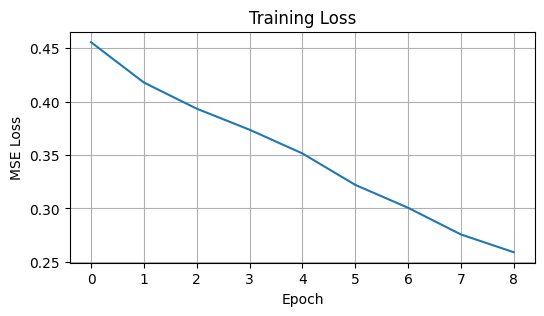

In [12]:
plt.figure(figsize=(6, 3))
plt.plot(train_loss_list[1:])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [13]:
model.eval()
predictions, targets_all = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs)
        targets_all.extend(targets.numpy())

mse = mean_squared_error(targets_all, predictions)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0056


In [14]:
# plt.figure(figsize=(10, 4))
# plt.plot(predictions[1000:1500], label="Predicted")
# plt.plot(targets_all[1000:1500], label="True", alpha=0.7)
# plt.legend()
# plt.title("LSTM Prediction")
# plt.xlabel("Sample")
# plt.ylabel("Steering Angle")
# plt.tight_layout()
# plt.show()